<h1 style="text-align:center"><mark><u>2 Mass-Spring-Damping Model</u></mark></h1>
<h3 style="text-align:center"> MCHE 599: Masters Thesis Research</h3> 
<p style="text-align:center">Dr. Joshua Vaughan and Joshua Hebert<br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
http://www.ucs.louisiana.edu/~jev9637/   </p>

<p style="text-align:center">
	<img src="http://localhost:8888/files/Documents/GitHub/2-mass-model/2%20mass%20spring%20with%20damping%20FBD.jpg" alt="2 Mass-Spring-Damper System" width=50%/></a><br>
    <strong> Figure 1: 2 Mass-Spring System  with Damping </strong>
</p>

This notebook solves the equations of motion of a simple 2 mass-spring system like the one shown in Figure 1.

The equations of motion for the system are:

(1)$ \quad M_1 \ddot{x_1} + C_1\dot{x_1} + K_1\cdot(x_1 - x_w) + K_2\cdot(x_1-x_2) = 0 $<br>

(2)$\quad M_2 \ddot{x_2} + C_2\dot{x_2}- K_2\cdot(x_1-x_2) = 0 $

We could also write this equation in state-space form:

$ \quad \dot{\bar{W}} = A\bar{W} + B u$<br>
<br>
where:
$ \quad A = \begin{bmatrix}0 & 1 & 0 & 0 \\ -(K_1 + K_2)/M_1 & -C_1/M_1 & K_2/M_1 & 0 \\ 0 & 0 & 0 & 1 \\ K_2/M_2 & 0 & -K_2/M_2 & -C_2/M_2\end{bmatrix} $$ \quad \bar{W} = \begin{bmatrix}w_1 \\ w_2 \\ w_3 \\ w_4\end{bmatrix} $$ \quad \bar{B} = \begin{bmatrix}0 \\ K_1/M_1 \\ 0 \\ 0\end{bmatrix} $$\quad u = x_w(t) = \sum_{i=1}^{N}A_i \cdot \sin(\omega_{i}t + \phi_{i}) $

For information on how to obtain this equation, you can see the lectures at the [class website](http://www.ucs.louisiana.edu/~jev9637/MCHE485.html).

In [2]:
import numpy as np              # Grab all of the NumPy functions with nickname np

In [3]:
# We want our plots to be displayed inline, not in a separate window
%matplotlib inline

# Import the plotting functions  
import matplotlib.pyplot as plt

# Import the ODE solver for our time response analysis
from scipy.integrate import odeint  

In [43]:
# Define the System Parameters
M1 = 90e6                 # kg (average weight of modern drillships ~200 Mlb)
wn1 = .732                # Natural Frequency (rad/s) of the drillship from FFT of measured data,- 
                          # typical range between .628 to .880 from literature
K1 = wn1**2 * M1          # N/m 
#wn = np.sqrt(k / m)      # Natural Frequency (rad/s)
z1 = .1
z2 = .1
C1 = 2*M1*wn1*z1

#z = 0.25                 # Define a desired damping ratio *commented out becasue this model assumes no damping
#c = 2 * z * wn * m       # calculate the damping coeff. to create it (N/(m/s))*commented out becasue this model- 
                          # assumes no damping

#wd = wn*np.sqrt(1-z**2)  # Damped natural frequency (rad/s) *commented out becasue this model assumes no damping
print("K1 = ",round(K1/1000,0),"kN/m")

M2 = 888e3                # kg (calculated from 2 mass model code, total string weight)
K2 = 496e3                # N/m (calculated from 2 mass model code, equivalent total string stiffness)
wn2 = np.sqrt(K2/M2)      # Natural Frequency (rad/s) of total string
C2 = 2*M2*wn2*z2
print("wn2 =",round(wn2,3),"rad/s")

K1 =  48224.0 kN/m
wn2 = 0.747 rad/s


## Pierson-Moskowitz Spectrum

The Pierson-Moskowitz spectra was developed in 1964 from measurements in the North Atlantic.  It is an empirical relationship of the distribution of energy through ocean wave frequencies.  Thus, for a given wind speed, a range of wave frequencies may be calculated with an appropriate energy distribution that is representative of an ocean wave field.

The Pierson-Moskowitz energy desnity spectrum is:

$$S(\omega) = \frac{A_{sp}}{\omega^{5}}exp\bigg(-\frac{B_{sp}}{\omega^{4}}\bigg) $$

where $A_{sp}$ is:

$$A_{sp} = 8.1 \cdot 10^{-3} \cdot g^{2}$$

and

$$B_{sp} = \frac{3.11}{H_{s}^{2}} $$

and

$$H_{s} = 0.21 \frac{V^{2}}{g} $$

To calculate wave position, the frequency range is divided into parts. The following equation represents the harmonic wave spread:

$$s(t) = \sum_{i=1}^{N}s_{i} = \sum_{i=1}^{N}A_i \cdot \sin(\omega_{i}t + \phi_{i}) $$

$\phi_{i}$ is a random phase angle uniformly distributed and constant with time from 0 to $2\pi$.

$A_{i}$ is

$$ A_{i} = \sqrt{2 \cdot S(\omega_{i}) \cdot \Delta\omega} $$

$\Delta\omega$ is the length of the division of the spectral density function $S(\omega)$

In [44]:
# Setting up the matrices

#def Wss(w,t,p):                              #Wss = W state-space function
#A = np.array([[0,1,0,0],[-(K1+K2)/M1,0,K2/M1,0],[0,0,0,1],[K2/M2,0,-K2/M2,0]])

#defining the values of the W matrix
###############################################################################################################Bobby's PM Top
#PM Wave Height from Bobby's PM Spectrum code

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 120.0                 #seconds
numpoints = 10001

# Set up the parameters for the input function
StartTime = 0.0              # Time the f(t) input will begin
A_amp = 2.0                # Amplitude of Disturbance wave (m)
omega = 1     # Natural Frequency (rad/s) of waves

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)
stoptimemin = stoptime/60

#Bobby's Parameters:
#     Declaration of variables
V_knots = 30.     # In knots 15 original
g = 9.81          # Gravity m/s^2
N = 5             # Number of desired frequencies
omega_1 = 1.5     #rad/s
omega_5 = 5       #rad/s
phi_1 = 0         #rad
phi_5 = 2*np.pi   #rad

#V_knots, g, omega, A_sp, B_sp, S, delta_omega, A_i, omega_i, g, t, phi_i, 
V = V_knots * 0.5144    # Conversion from knots to m/s
H_s = 0.21 * (V**2 / g) #m

A_sp = 8.1 * 10**-3 * g**2
B_sp = 3.11 / H_s**2

delta_omega = (omega_5-omega_1)/N
omega_2 = omega_1 + delta_omega
omega_3 = omega_2 + delta_omega
omega_4 = omega_3 + delta_omega

delta_phi = (phi_5 - phi_1)/N
phi_2 = phi_1 + delta_phi      #+np.pi*rand() or rand() - rand()  to center the random number about pi or 0
phi_3 = phi_2 + delta_phi
phi_4 = phi_3 + delta_phi

#  IS THIS RANGE OF PHI SUFFICIENT TO GENERATE RANDOM VALUES?  THIS PROCEDURE DIVIDES THE COMPLETE REVOLUTION RANGE BY N.

S_1 = (A_sp / omega_1**5) * np.exp(-B_sp / omega_1**4)
S_2 = (A_sp / omega_2**5) * np.exp(-B_sp / omega_2**4)
S_3 = (A_sp / omega_3**5) * np.exp(-B_sp / omega_3**4)
S_4 = (A_sp / omega_4**5) * np.exp(-B_sp / omega_4**4)
S_5 = (A_sp / omega_5**5) * np.exp(-B_sp / omega_5**4)

A_1 = np.sqrt(2 * S_1 * delta_omega)
A_2 = np.sqrt(2 * S_2 * delta_omega)
A_3 = np.sqrt(2 * S_3 * delta_omega)
A_4 = np.sqrt(2 * S_4 * delta_omega)
A_5 = np.sqrt(2 * S_5 * delta_omega)


###############################################################################################################Bobby's PM Bot

def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the direct-force mass-spring-damper system.

    Arguments:
        w :  vector of the state variables:
        t :  time
        p :  vector of the parameters:
    """
    x, x_dot, y, y_dot = w
    [M1, M2, K1, K2, StartTime, A_amp, omega, A_1, A_2, A_3, A_4, A_5, omega_1, omega_2, omega_3, omega_4, omega_5,
     phi_1, phi_2, phi_3, phi_4, phi_5, C1, C2] = p
    
    # Create sysODE = (x', x_dot', y', y_dot') 
    #x = x1, x_dot = x1_dot, y = x2, y_dot = x2_dot
    sysODE = [x_dot,
              -C1/M1 * x_dot -(K1 + K2)/M1 * x + K2/M1 * y + x_wave(t, p),
              y_dot, 
              -C2/M2 * y_dot + K2/M2 * x - K2/M2 * y]
    return sysODE

def x_wave(t, p):
    """
    defines the disturbance wave input to the system
    """
    [M1, M2, K1, K2, StartTime, A_amp, omega, A_1, A_2, A_3, A_4, A_5, omega_1, omega_2, omega_3, omega_4, omega_5,
    phi_1, phi_2, phi_3, phi_4, phi_5, C1, C2] = p
    
    #    Need to sum up several omega's from Bobby's PM Spectrum notebook here
#    x_wave = K1/M1 * A_amp * np.sin(omega * t)   #original wave input, single frequency and amplitude, no phase shift
#    x_wave = K1/M1 * (A_amp * np.sin(omega * t) + A_amp*1.1342 * np.sin(omega*t*1.2452+1.1452) 
#                      + A_amp*.8956 * np.sin(omega*t*1.6+3.56) + A_amp*1.425 * np.sin(omega*t*.526+5.263)
#                     + A_amp*.6854 * np.sin(omega*t*.428+4.5356))  #2nd wave input, combination of 5 
#                                                                   randomly chosen frequencies
#    x_wave = K1/M1 * A_amp * np.sin(omega * t)
    x_wave = K1/M1 * (A_1 * np.sin(omega_1 * t + phi_1) + A_2 * np.sin(omega_2 * t + phi_2) +
                       A_3 * np.sin(omega_3 * t + phi_3) + A_4 * np.sin(omega_4 * t + phi_4) +
                       A_5 * np.sin(omega_5 * t + phi_5))
    return x_wave

              
#print('x_wave = ')
#print(x_wave(t,p))


In [45]:
# Set up simulation parameters

# Initial conditions
x_init = 0.0                        # initial position
x_dot_init = 0.0                    # initial velocity
y_init = 0.0                        # initial position
y_dot_init = 0.0                    # initial velocity

# Pack the parameters and initial conditions into arrays  
p = [M1, M2, K1, K2, StartTime, A_amp, omega, A_1, A_2, A_3, A_4, A_5, omega_1, omega_2, omega_3, omega_4, omega_5,
    phi_1, phi_2, phi_3, phi_4, phi_5, C1, C2]
x0 = [x_init, x_dot_init, y_init, y_dot_init]

In [46]:
# Call the ODE solver.
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

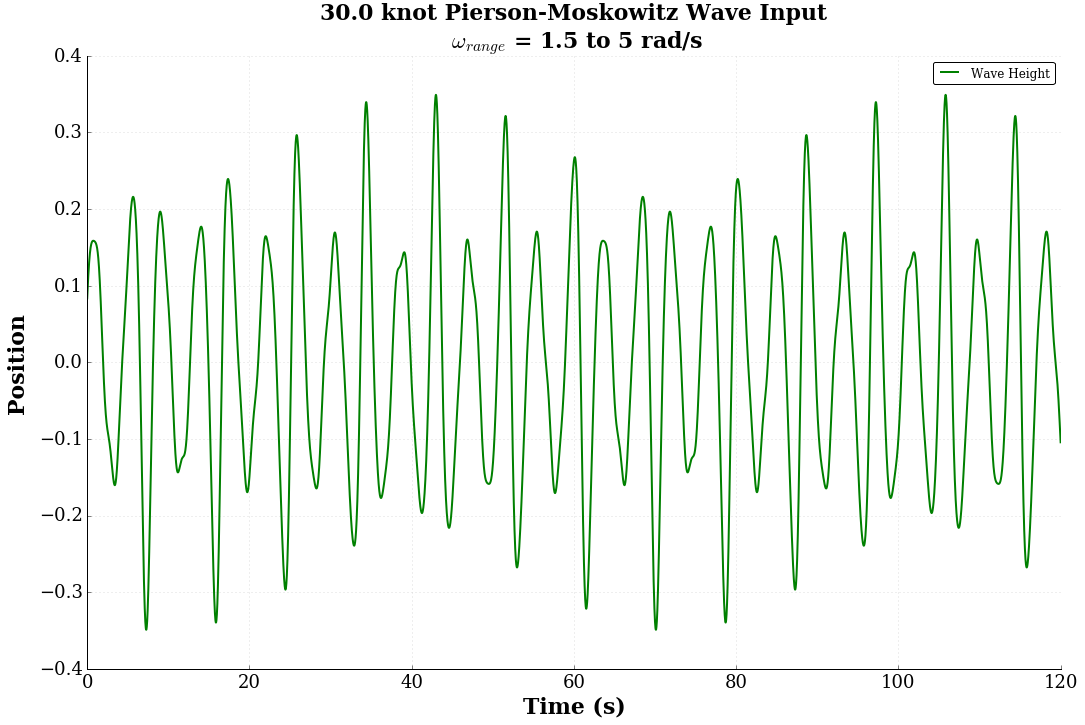

In [47]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('%s knot Pierson-Moskowitz Wave Input\n $\omega_{range}$ = %s to %s rad/s'%(V_knots, omega_1, omega_5), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')
#plt.plot(t, total_wave, linewidth=2, color='lightgreen', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('%s knot Pierson-Moskowitz Wave Input %s to %s Reparied 2 mass model.pdf'%(V_knots, omega_1, omega_5)) #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

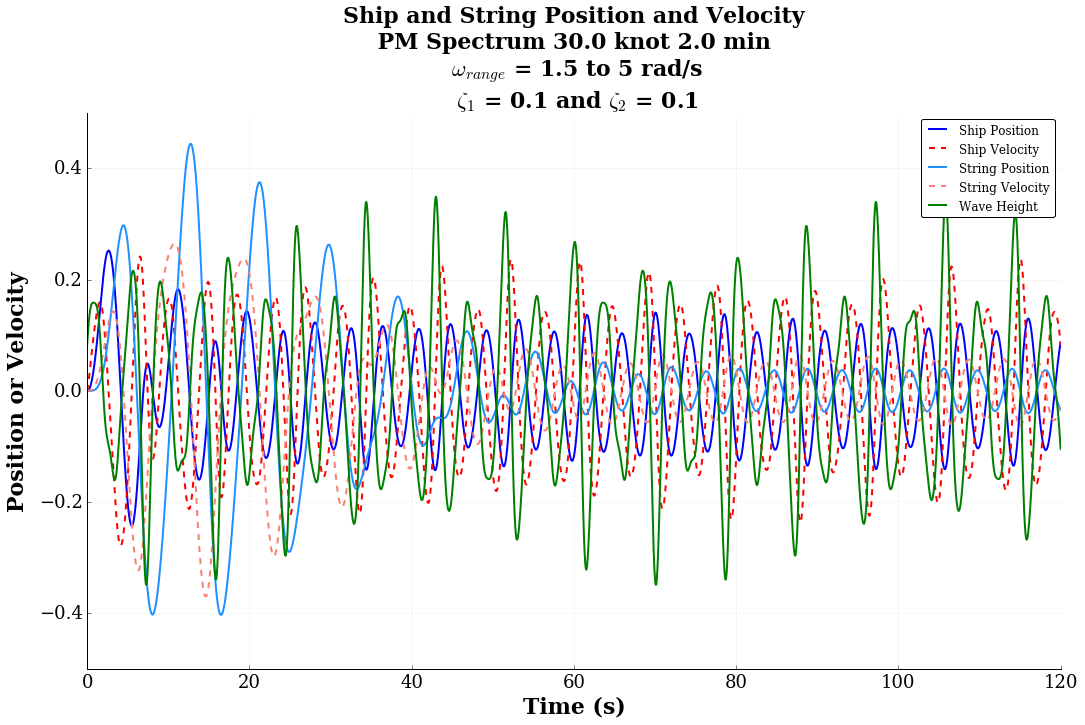

In [52]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position or Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Position and Velocity\n PM Spectrum %s knot %s min \n $\omega_{range}$ = %s to %s rad/s \n $\zeta_1$ = %s and $\zeta_2$ = %s'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2), family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Combined %s knot %s min %s to %s with %s and %s damping ratios 2 mass model.pdf'%(V_knots, stoptimemin, omega_1, omega_5, z1, z2)) #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)


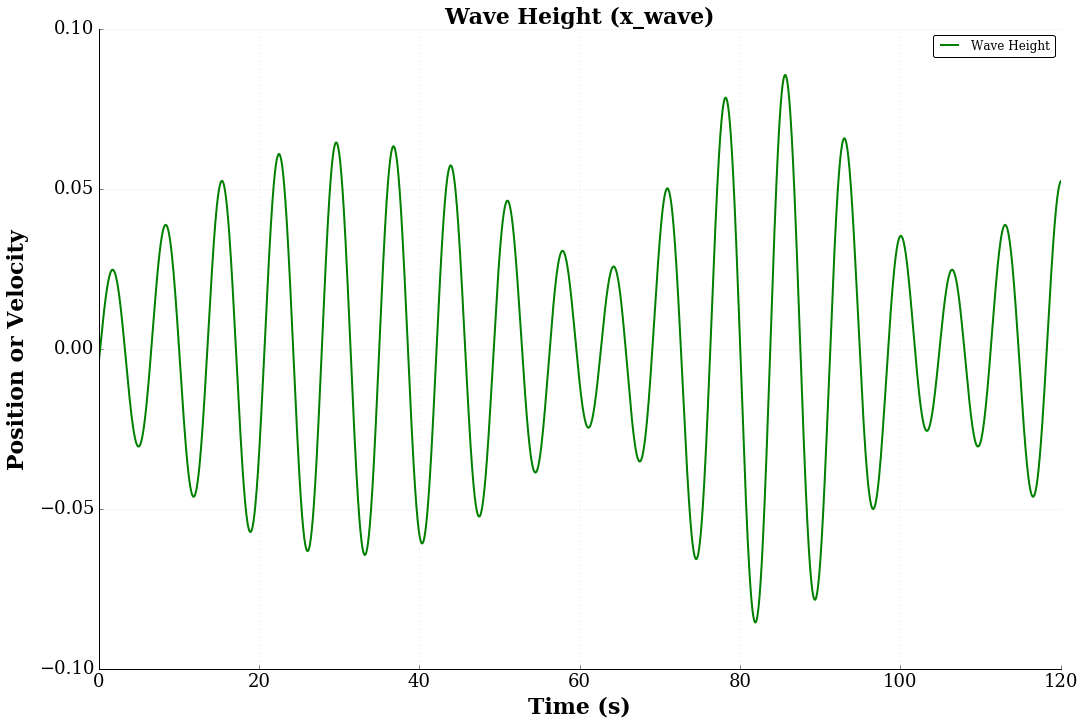

In [55]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position or Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Wave Height (x_wave)', family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')
plt.plot(t, x_wave(t, p), linewidth=2, color='green', linestyle = '-', label=r'Wave Height')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=12)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Combined Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

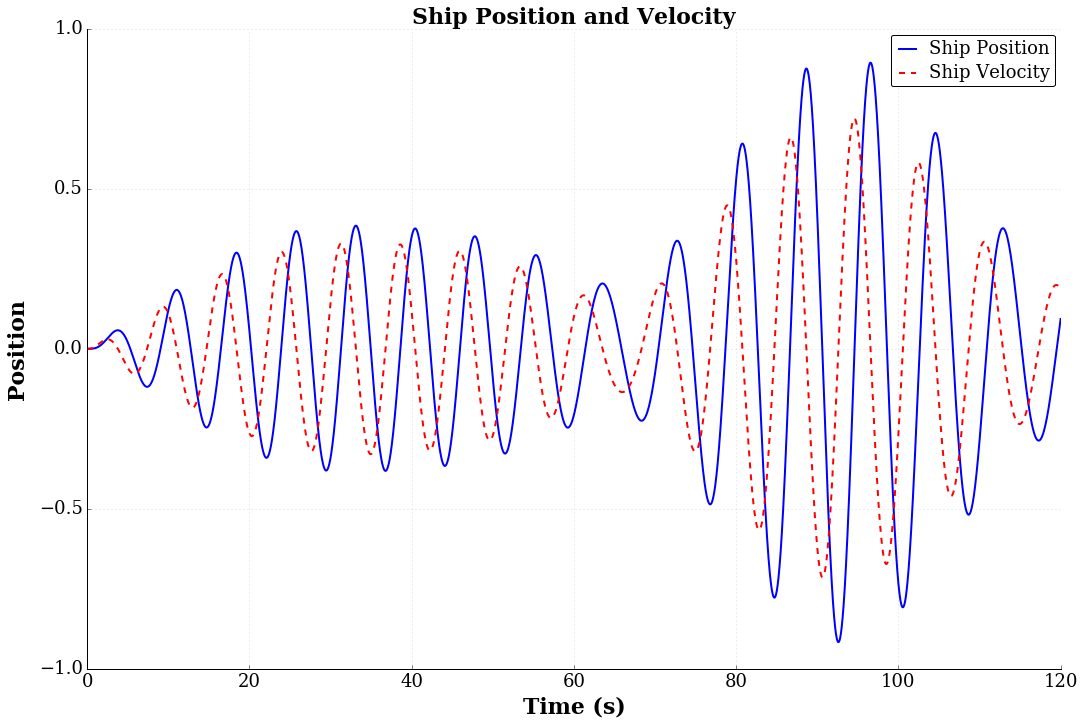

In [56]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship Position and Velocity', family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship Position and Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

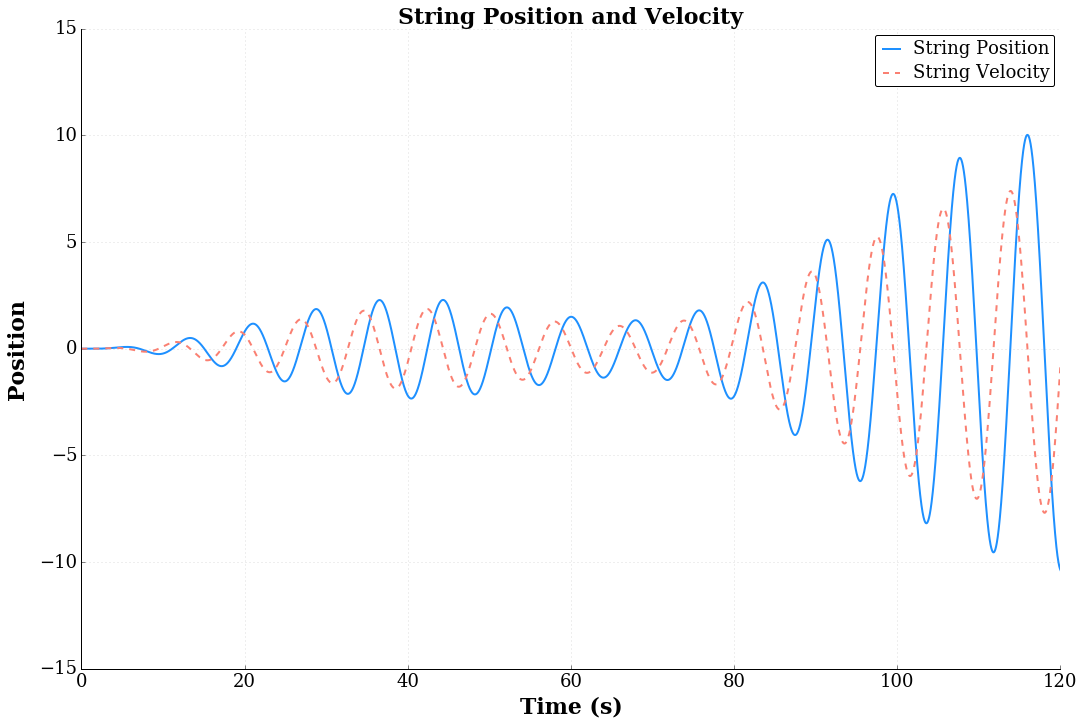

In [57]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Position and Velocity', family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Position and Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

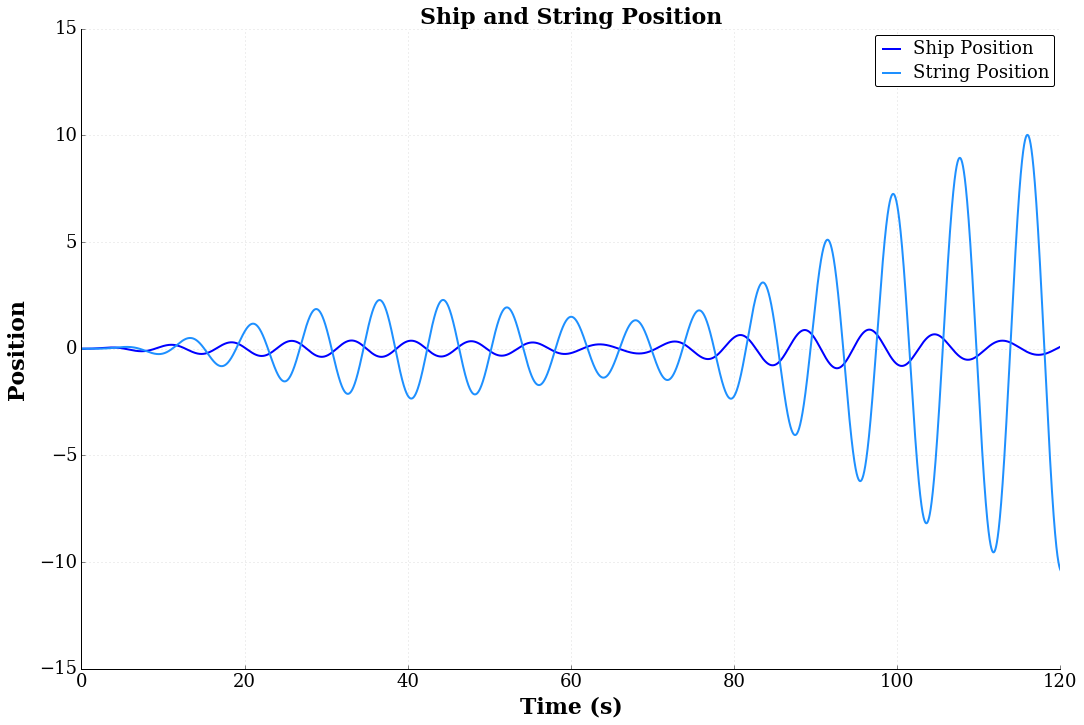

In [58]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Position', family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
#plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
#plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship and String Position Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

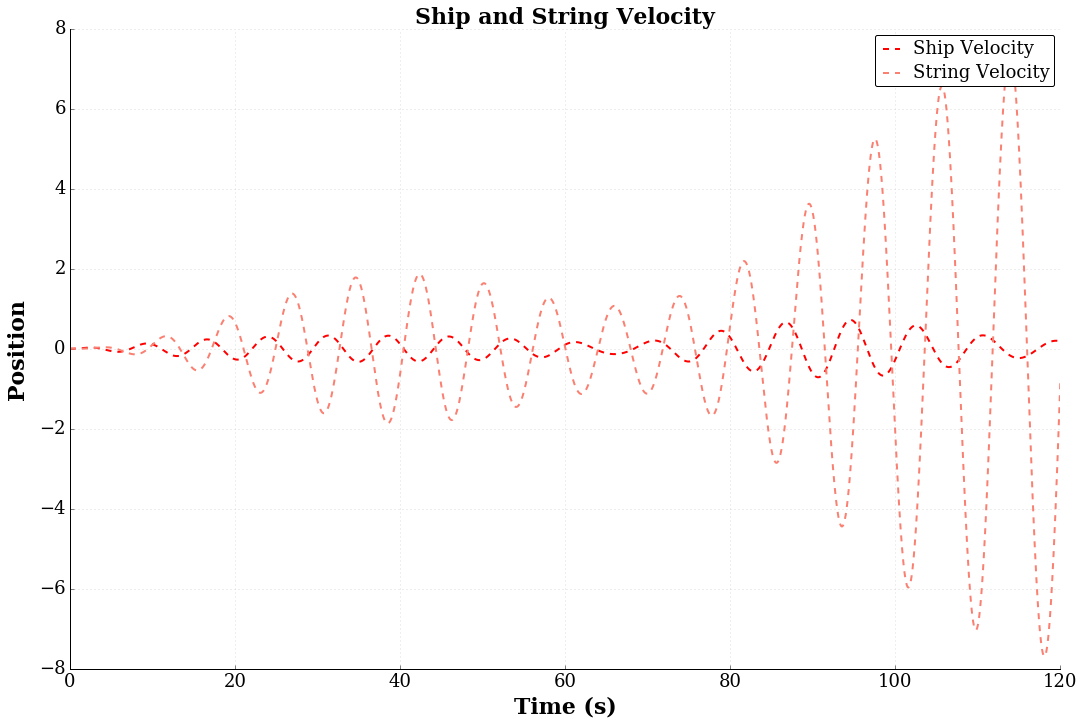

In [59]:
# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(15, 10)) #original (6,4)
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship and String Velocity', family='serif', fontsize=22, weight='bold')

# Plot the first element of resp for all time. It corresponds to the position.
#plt.plot(t, resp[:,0], linewidth=2, color='b', linestyle = '-', label=r'Ship Position')
plt.plot(t, resp[:,1], linewidth=2, color='r', linestyle = '--', label=r'Ship Velocity')
#plt.plot(t, resp[:,2], linewidth=2, color='dodgerblue', linestyle = '-', label=r'String Position')
plt.plot(t, resp[:,3], linewidth=2, color='salmon', linestyle = '--', label=r'String Velocity')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship and String Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 10) # Resize the figure for better display in the notebook original (9,6)

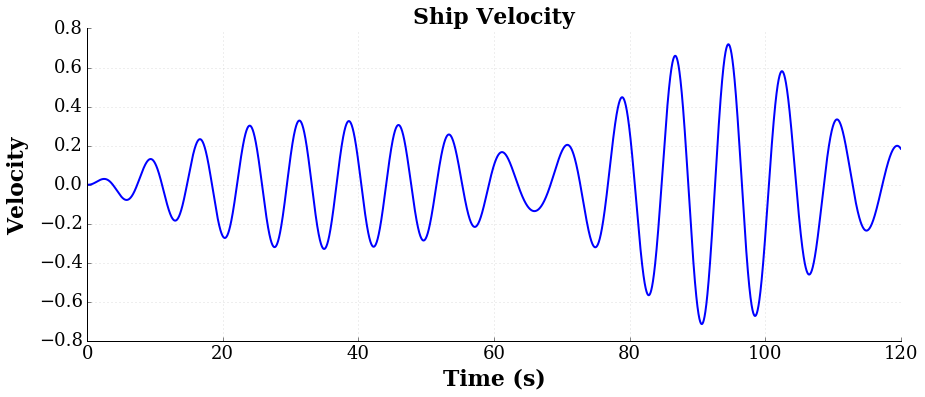

In [60]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('Ship Velocity', family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,1], linewidth=2, linestyle = '-', label=r'Response')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('Ship Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 6) # Resize the figure for better display in the notebook original (9,6)

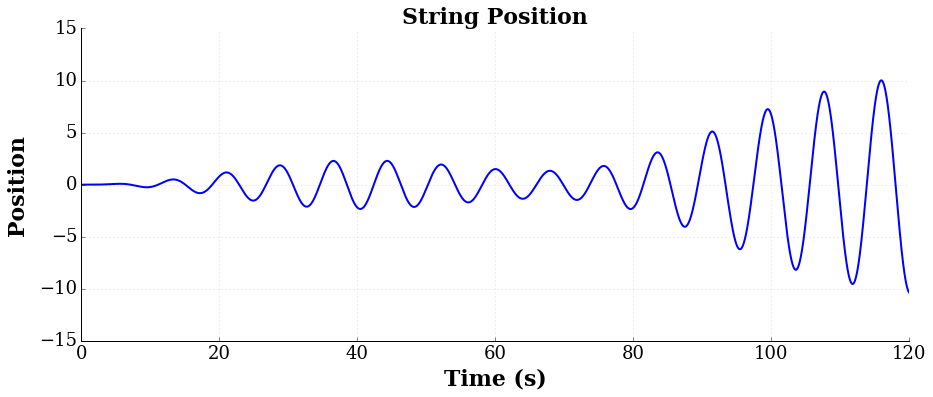

In [61]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Position', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Position', family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,2], linewidth=2, linestyle = '-', label=r'Response')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Position Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 6) # Resize the figure for better display in the notebook original (9,6)

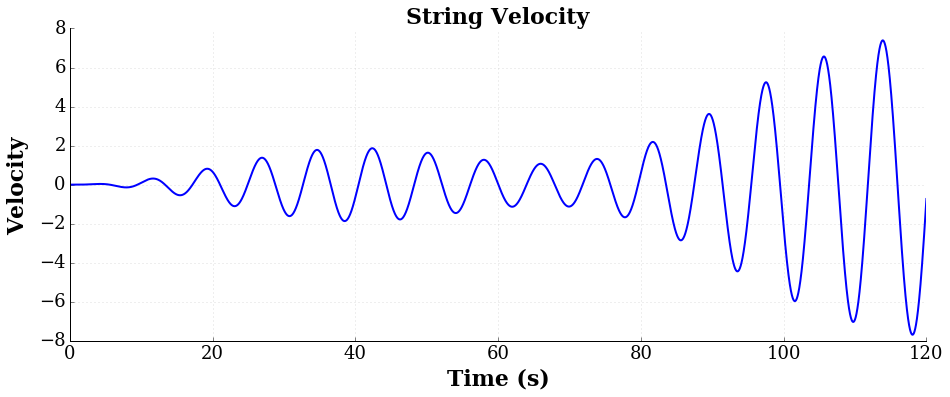

In [62]:
# Make the figure pretty, then plot the results - PLOTTING OTHER VARIABLES
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='serif',fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Velocity', family='serif', fontsize=22, weight='bold', labelpad=10)
plt.title('String Velocity', family='serif', fontsize=22, weight='bold')

# Plot the second element of resp for all time. It corresponds to the position.
plt.plot(t, resp[:,3], linewidth=2, linestyle = '-', label=r'Response')

# uncomment below and set limits if needed
plt.xlim(0,stoptime)
# ylim(0,10)

# # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext,family='serif',fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad = 0.5)

# save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
#plt.savefig('String Velocity Reparied 2 mass model.pdf') #change file name to match plotted variable

fig.set_size_inches(15, 6) # Resize the figure for better display in the notebook original (9,6)

NameError: name 'w' is not defined

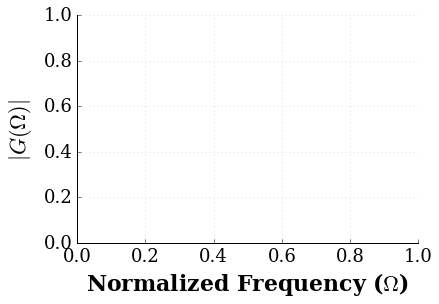

In [63]:
# Let's plot the magnitude of the frequency response

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Normalized Frequency ($\Omega$)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'$|G(\Omega)|$',family='Serif',fontsize=22,weight='bold',labelpad=10)

plt.plot(w,mag_normal_un,  linewidth=2, linestyle = ':',   label=r'$\zeta = 0.0$')
plt.plot(w,mag_normal_0p1, linewidth=2, linestyle = '-',   label=r'$\zeta = 0.1$')
plt.plot(w,mag_normal_0p2, linewidth=2, linestyle = '-.',  label=r'$\zeta = 0.2$')
plt.plot(w,mag_normal_0p4, linewidth=2, linestyle = '--',  label=r'$\zeta = 0.4$')

plt.xlim(0,5)
plt.ylim(0,10)

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# savefig('Seismic_Freq_Resp_mag.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

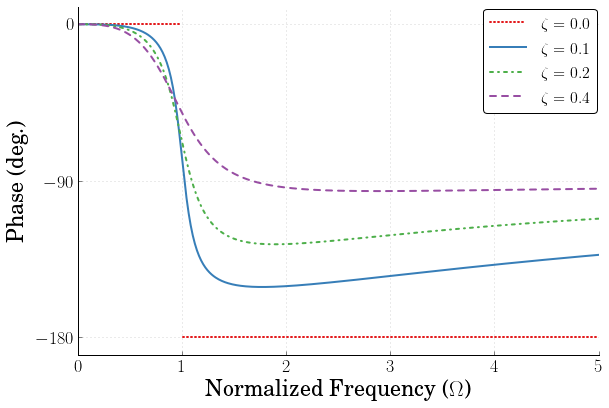

In [6]:
# Now, let's plot the Phase Frequency Response

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Normalized Frequency ($\Omega$)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'Phase (deg.)$',family='Serif',fontsize=22,weight='bold',labelpad=8)

plt.plot(w,phase_un,  linewidth=2,  linestyle = ':',  label=r'$\zeta = 0.0$')
plt.plot(w,phase_0p1, linewidth=2, linestyle = '-',  label=r'$\zeta = 0.1$')
plt.plot(w,phase_0p2, linewidth=2, linestyle = '-.', label=r'$\zeta = 0.2$')
plt.plot(w,phase_0p4, linewidth=2, linestyle = '--', label=r'$\zeta = 0.4$')

plt.xlim(0,5)
plt.ylim(-190,10)
plt.yticks([-180,-90,0])

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('Seismic_Freq_Resp_Phase.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

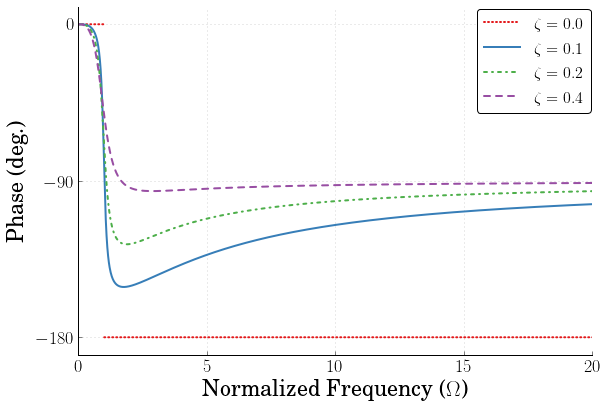

In [7]:
# Plot the Phase Frequency Response over a larger range of frequencies

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
plt.setp(ax.get_ymajorticklabels(),family='Serif',fontsize=18)
plt.setp(ax.get_xmajorticklabels(),family='Serif',fontsize=18)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.grid(True,linestyle=':',color='0.75')
ax.set_axisbelow(True)

plt.xlabel(r'Normalized Frequency ($\Omega$)',family='Serif',fontsize=22,weight='bold',labelpad=5)
plt.ylabel(r'Phase (deg.)$',family='Serif',fontsize=22,weight='bold',labelpad=8)

plt.plot(w,phase_un,  linewidth=2, linestyle = ':',  label=r'$\zeta = 0.0$')
plt.plot(w,phase_0p1, linewidth=2, linestyle = '-',  label=r'$\zeta = 0.1$')
plt.plot(w,phase_0p2, linewidth=2, linestyle = '-.', label=r'$\zeta = 0.2$')
plt.plot(w,phase_0p4, linewidth=2, linestyle = '--', label=r'$\zeta = 0.4$')

plt.ylim(-190,10)
plt.yticks([-180,-90,0])

leg = plt.legend(loc='upper right', fancybox=True)
ltext  = leg.get_texts() 
plt.setp(ltext,family='Serif',fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# plt.savefig('Seismic_Freq_Resp_Phase_Extended.pdf',dpi=600)

fig.set_size_inches(9,6) # Resize the figure for better display in the notebook

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [8]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(open(css_file, "r").read())